## Customer Support Assistant Workflow
This notebook builds a workflow that takes a customer support message, detects its intent (Billing, Technical, Account, or General), analyzes sentiment (Positive, Neutral, Negative), and routes it to the right department or FAQ bot. If the sentiment is negative, the query is escalated to a supervisor. 

This notebook explores how to define the state, write each node, set up the routing logic, visualize the workflow, and test it with real example queries.

### Import required libraries

In [75]:
import os
from typing import TypedDict, Optional
from langchain.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import display, Image
from dotenv import load_dotenv

### Load environment variables including Google api key

In [76]:
# Load environment variables
load_dotenv()

# Set Google api key
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

### Define state for customer support

In [77]:
class SupportTicketState(TypedDict):
    """State schema for the customer support workflow"""

    # Input
    query_text: str

    # Analysis Results
    intent: Optional[str]  # billing, technical, account, general
    sentiment: Optional[str]  # positive, neutral, negative

    # Routing
    department: Optional[str]  # billing, technical, account
    escalated: bool

    # Response
    response_text: Optional[str]


### Initiate LLM

In [78]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
)

### Define nodes

In [79]:
# Intent Classification node
def intent_classification_node(
    state: SupportTicketState,
) -> dict:
    """Classify the intent of the support query."""
    prompt = PromptTemplate(
        input_variables=["query_text"],
        template=(
            "Classify the intent of the following support query as one of: billing, technical, account, general.\n"
            "Query: {query_text}\n"
            "Intent:"
        ),
    )

    response = llm.invoke(prompt.format(query_text=state["query_text"]))

    intent = response.content.strip().lower()

    if intent not in ["billing", "technical", "account", "general"]:
        intent = "general"

    return {"intent": intent}


# Sentiment Analysis node
def sentiment_analysis_node(
    state: SupportTicketState,
) -> dict:
    """Analyze the sentiment of the support query."""
    prompt = PromptTemplate(
        input_variables=["query_text"],
        template=(
            "Analyze the sentiment of the following support query as ONE of: positive, neutral, negative.\n"
            "Query: {query_text}\n"
            "Sentiment:"
        ),
    )

    response = llm.invoke(prompt.format(query_text=state["query_text"]))

    sentiment = response.content.strip().lower()

    if sentiment not in ["positive", "neutral", "negative"]:
        sentiment = "neutral"

    return {"sentiment": sentiment}


# FAQ Bot Node
def faq_bot_node(state: SupportTicketState) -> dict:
    prompt = PromptTemplate(
        input_variables=["query_text"],
        template=(
            "Provide a short, helpful response to the following general support query.\n"
            "Query: {query_text}\n"
            "Response (1-2 sentences):"
        ),
    )

    response = llm.invoke(prompt.format(query_text=state["query_text"]))

    return {"response_text": response.content.strip()}


# Department Nodes
def billing_node(state: SupportTicketState) -> dict:
    return {
        "response_text": "Billing Department.",
        "department": "Billing",
    }


def technical_node(state: SupportTicketState) -> dict:
    return {
        "response_text": "Technical Support team.",
        "department": "Technical",
    }


def account_node(state: SupportTicketState) -> dict:
    return {
        "response_text": "Account Help team.",
        "department": "Account",
    }


# Supervisor Escalation Node
def supervisor_escalation_node(state: SupportTicketState) -> dict:
    return {
        "escalated": True,
        "response_text": (state.get("response_text") or "")
        + " [Escalated to Supervisor.]",
    }


# Routing Logic Node
def routing_node(state: SupportTicketState) -> dict:
    """Return department as a single key dict for routing."""
    if state["intent"] == "general":
        return {"department": "faq_bot"}
    elif state["intent"] == "billing":
        return {"department": "billing"}
    elif state["intent"] == "technical":
        return {"department": "technical"}
    elif state["intent"] == "account":
        return {"department": "account"}
    else:
        return {"department": "faq_bot"}


### Build the workflow

In [80]:
workflow = StateGraph(SupportTicketState)


# Add nodes
workflow.add_node("intent_classification", intent_classification_node)
workflow.add_node("sentiment_analysis", sentiment_analysis_node)
workflow.add_node("routing", routing_node)
workflow.add_node("faq_bot", faq_bot_node)
workflow.add_node("billing", billing_node)
workflow.add_node("technical", technical_node)
workflow.add_node("account", account_node)
workflow.add_node("supervisor_escalation", supervisor_escalation_node)


# Edges
def escalate_if_negative(state: SupportTicketState) -> str:
    if state.get("sentiment") == "negative":
        return "supervisor_escalation"
    return "end"

workflow.add_edge(START, "intent_classification")
workflow.add_edge("intent_classification", "sentiment_analysis")
workflow.add_edge("sentiment_analysis", "routing")
workflow.add_conditional_edges(
    "routing",
    lambda state: state["department"],
    {
        "faq_bot": "faq_bot",
        "billing": "billing",
        "technical": "technical",
        "account": "account",
    },
)
# After department/FAQ, check for escalation
for node in ["faq_bot", "billing", "technical", "account"]:
    workflow.add_conditional_edges(
        node,
        escalate_if_negative,
        {"supervisor_escalation": "supervisor_escalation", "end": END},
    )
workflow.add_edge("supervisor_escalation", END)

# Compile
app = workflow.compile()

### Visualize the workflow

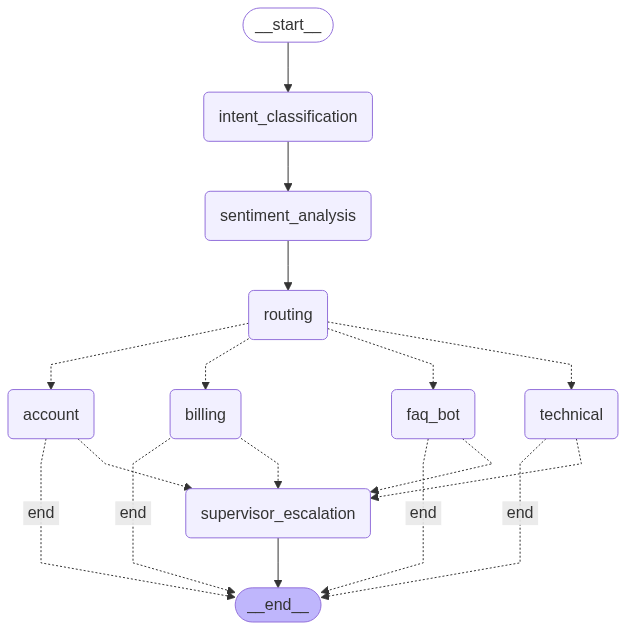

In [81]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Test pipeline

In [82]:
queries = [
    {
        "query_text": "I'm really frustrated because my payment keeps getting declined even though I know my card works."
    },
    {"query_text": "How do I reset my password?"},
    {"query_text": "The app keeps crashing when I try to upload a file."},
    {"query_text": "Thank you for your help, everything works great!"},
]

for i, query in enumerate(queries, 1):
    result = app.invoke(query)
    print("\n" + "="*40)
    print(f"Sample Query {i}")
    print("-"*40)
    print(f"Query: {result.get('query_text','')}")
    print(f"Intent: {result.get('intent','')}")
    print(f"Sentiment: {result.get('sentiment','')}")
    print(f"Department: {result.get('department','')}")
    print(f"Escalated: {result.get('escalated', False)}")
    print(f"Response: {result.get('response_text','')}")
    print("="*40)


Sample Query 1
----------------------------------------
Query: I'm really frustrated because my payment keeps getting declined even though I know my card works.
Intent: billing
Sentiment: negative
Department: Billing
Escalated: True
Response: Billing Department. [Escalated to Supervisor.]

Sample Query 2
----------------------------------------
Query: How do I reset my password?
Intent: account
Sentiment: neutral
Department: Account
Escalated: False
Response: Account Help team.

Sample Query 2
----------------------------------------
Query: How do I reset my password?
Intent: account
Sentiment: neutral
Department: Account
Escalated: False
Response: Account Help team.

Sample Query 3
----------------------------------------
Query: The app keeps crashing when I try to upload a file.
Intent: technical
Sentiment: negative
Department: Technical
Escalated: True
Response: Technical Support team. [Escalated to Supervisor.]

Sample Query 3
----------------------------------------
Query: The ap